<a href="https://colab.research.google.com/github/toccht/CSCI-4962/blob/main/CSCI4962-HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI-4962 Homework 3
Author: Trevor Tocchet

# Framework Research

I used the Keras framework for most of the implementation of the two-layer neural network. Keras is a high level interface for the TensorFlow library. It also helped with tuning the hyperparameters. The library made implementing a neural network intuitive and allowed a lot of flexibility when building/implementing the model.

Keras: https://keras.io/

SGD: https://keras.io/api/optimizers/sgd/

Hyperparameter Tuner: https://keras.io/keras_tuner/

More Resources
*   https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
*   https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5
*   https://www.pyimagesearch.com/2021/06/07/easy-hyperparameter-tuning-with-keras-tuner-and-tensorflow/



In [ ]:
pip install keras-tuner

In [4]:
import keras_tuner as kt
from tensorflow import keras
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Data
I choose the MNIST data set which is a well known deep learning data set that aims to predict handwritten digits to their corresponding number. This problem can extended to many applications like photo-to-text apps that turn handwriting into text on a device.

https://keras.io/api/datasets/mnist/

# Data Pre-Processing

In [ ]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(trainX, trainY), (testX, testY) = mnist.load_data()

# scale image data on normal distribution [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the labels
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# Neural Network Model

In [11]:
# two-layer neural network model
def build_model(hp):
  hp_units = hp.Int('units', min_value=8, max_value=64, step=8)
  
  model = keras.Sequential()

  # image is of size (28, 28) so we need to linearize it
  model.add(keras.layers.Flatten()) 

  model.add(keras.layers.Dense(hp_units, activation='relu'))
  model.add(keras.layers.Dense(10, activation='sigmoid'))

  lr = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])
  #mm = hp.Choice("momentum", values=[0.90, 0.91, 0.92, 0.93, 0.94, 0.95])

  sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=False, name="SGD")

  model.compile(loss='categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])

  return model

In [15]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    overwrite=True)

#tuner.search_space_summary()
tuner.search(trainX, trainY, epochs=2, validation_split=0.2, batch_size=32)

# print tuner summary results
tuner.results_summary()

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest learning rate for SGD is {}".format(best_hp.get('learning_rate')))
print("Best number number of nodes in the first hidden layer is {} nodes\n".format(best_hp.get('units')))

# build new neural network with best hyperparameters
model = tuner.hypermodel.build(best_hp)
history = model.fit(trainX, trainY, validation_split=0.2, batch_size=32, epochs=20, verbose=1)

print() # output formatting

_, accuracy = model.evaluate(testX, testY)
print("Tuned model has {:.2f}% accuracy on the test data".format(accuracy*100))

Trial 10 Complete [00h 00m 05s]
val_accuracy: 0.8880833387374878

Best val_accuracy So Far: 0.9577500224113464
Total elapsed time: 00h 01m 21s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.9577500224113464
Trial summary
Hyperparameters:
units: 48
learning_rate: 0.01
Score: 0.950166642665863
Trial summary
Hyperparameters:
units: 48
learning_rate: 0.1
Score: 0.949833333492279
Trial summary
Hyperparameters:
units: 24
learning_rate: 0.001
Score: 0.9054166674613953
Trial summary
Hyperparameters:
units: 16
learning_rate: 0.001
Score: 0.9021666646003723
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.1
Score: 0.8880833387374878
Trial summary
Hyperparameters:
units: 48
learning_rate: 0.0001
Score: 0.8180000185966492
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.0001
Score: 0.8042500019073486
Trial

# Graphing

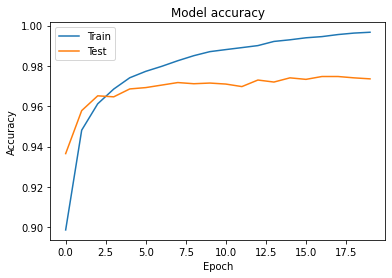

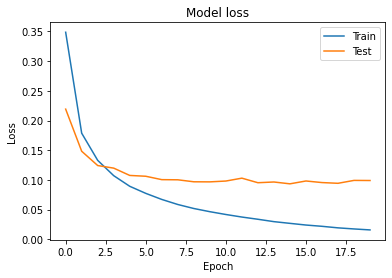

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Hyperparameter Choices
With more trials and an expanded range of nodes to test, the accuracy of the model has room to improve. Although, time is a factor when many more tests are added to the tuner. I chose RandomSearch because it is faster than other hyperparameter tuning algorithms such as Hyperband shown in this article: https://www.pyimagesearch.com/2021/06/07/easy-hyperparameter-tuning-with-keras-tuner-and-tensorflow/

I ran the model a few times to find a solid range for the number of nodes in the hidden layer. If time permitted and the testing/trials could run for long periods of time, an extended range of numbers would have increased the accuracy of the model. Also I opted to not tune momentum because the value of 0.9 worked the best for most cases, here is some research I looked at for determining momentum values: https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d